# Microsoft Stock Prediction Using LSTM

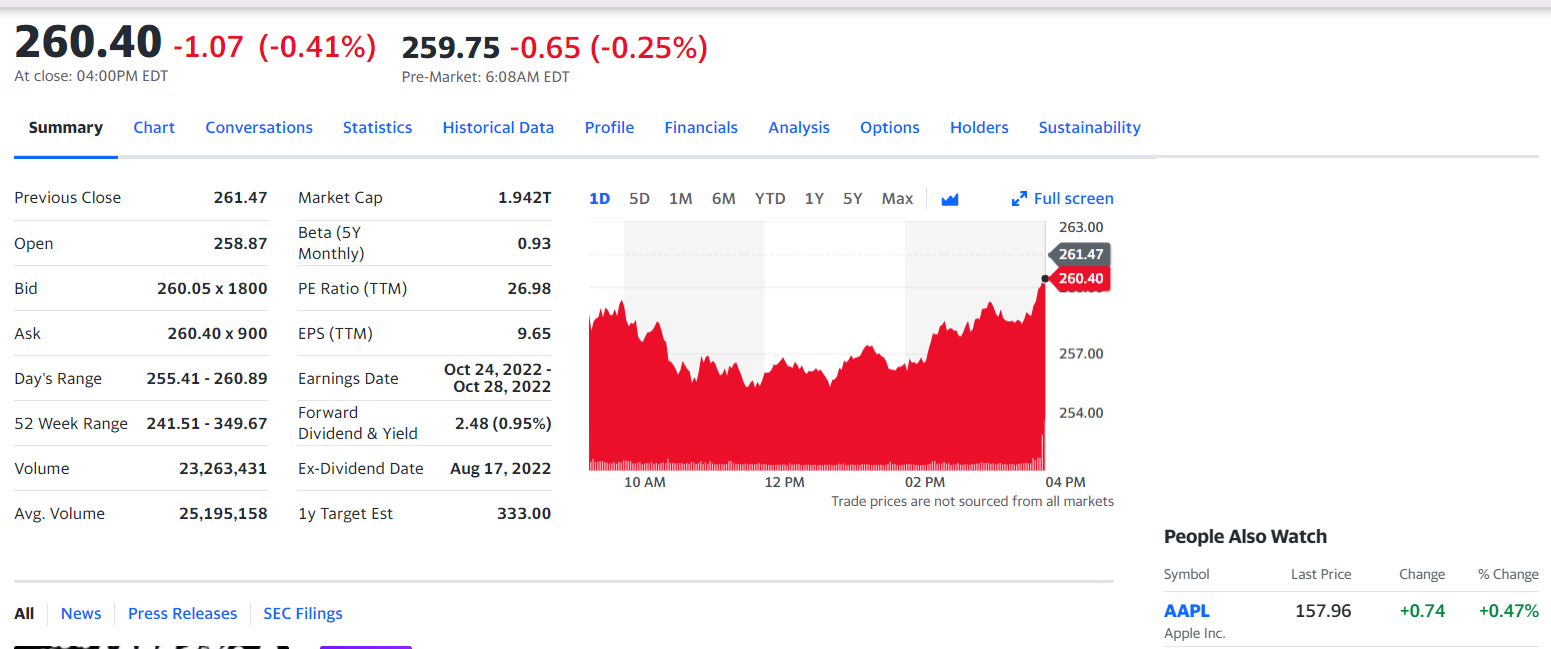

Microsoft Corporation is an American multinational technology corporation which produces computer software, consumer electronics, personal computers, and related services.

In this project we are going to apply deep learning models on the dataset of Microft stocks, which we have beend downloaded from Yahoo Finance Website. Then we will aply Data Analysis on it to visualize it. After that we will be computing its autocorrelation, mean, standard daviation. Before applying deep learning techniques on it. We will check its stationarity by using AdFuller method as we learned in the previous sections. 
So lets start our project by importing libraries.

# Import Libraries

In [36]:
import numpy as np

In [37]:
import pandas as pd

In [39]:
import matplotlib.pyplot as plt

In [40]:
df= pd.read_csv('MSFT.csv')

In [41]:
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,1/3/2017,62.790001,62.840000,62.130001,62.580002,57.807823,20694100
1,1/4/2017,62.480000,62.750000,62.119999,62.299999,57.549179,21340000
2,1/5/2017,62.189999,62.660000,62.029999,62.299999,57.549179,24876000
3,1/6/2017,62.299999,63.150002,62.040001,62.840000,58.047993,19922900
4,1/9/2017,62.759998,63.080002,62.540001,62.639999,57.863243,20382700


In [42]:
df.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
1421,8/25/2022,277.329987,279.019989,274.519989,278.850006,278.850006,16583400
1422,8/26/2022,279.079987,280.339996,267.980011,268.089996,268.089996,27532500
1423,8/29/2022,265.850006,267.399994,263.850006,265.230011,265.230011,20338500
1424,8/30/2022,266.670013,267.049988,260.660004,262.970001,262.970001,22767100
1425,8/31/2022,265.390015,267.109985,261.329987,261.470001,261.470001,24728900


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426 entries, 0 to 1425
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1426 non-null   object 
 1   Open       1426 non-null   float64
 2   High       1426 non-null   float64
 3   Low        1426 non-null   float64
 4   Close      1426 non-null   float64
 5   Adj_Close  1426 non-null   float64
 6   Volume     1426 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 78.1+ KB


In [45]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1.426000e+03
mean,169.561353,171.243268,167.753464,169.588822,165.923293,2.890647e+07
std,82.510456,83.402749,81.533050,82.509972,83.539829,1.262903e+07
min,62.189999,62.660000,61.950001,62.299999,57.549179,7.425600e+06
25%,98.414999,99.912503,97.302502,98.444999,93.971957,2.075820e+07
50%,142.135002,144.700005,139.805001,141.455002,137.402313,2.568230e+07
75%,243.832501,245.525005,241.487496,243.752502,240.720517,3.318965e+07
max,344.619995,349.670013,342.200012,343.109985,340.882782,1.112421e+08


In [46]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')

In [47]:
df.shape

(1426, 7)

In [48]:
df.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj_Close    False
Volume       False
dtype: bool

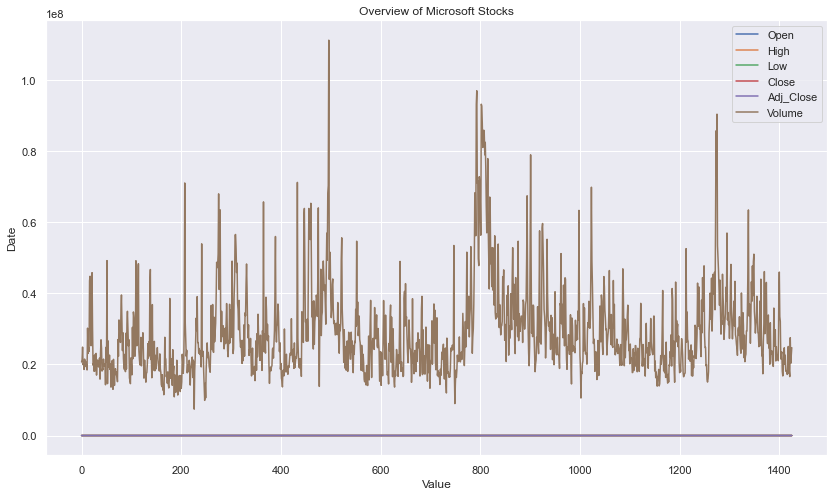

In [49]:
df.plot(kind='line',figsize=(14, 8))

plt.title('Overview of Microsoft Stocks')
plt.ylabel('Date')
plt.xlabel('Value')
plt.show()

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Text(0.5, 1.0, 'Mean over time')

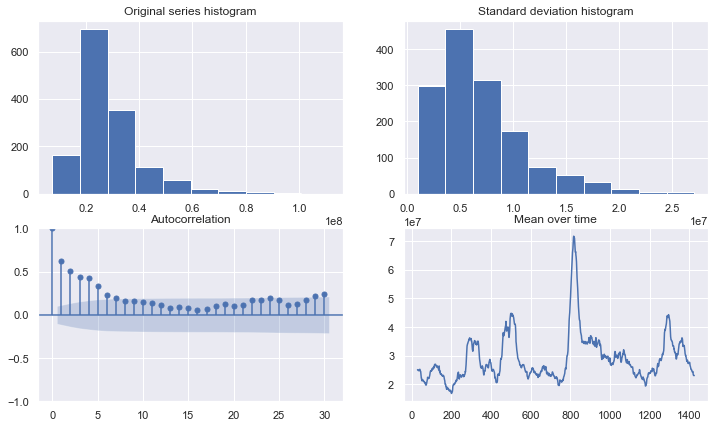

In [51]:
fig = plt.figure(figsize=(12, 7)) #ajust figure parameter
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0)) #obtain four diagrams 
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

df.Volume.hist(ax=hist_ax) #draw histogram of pollution_today
hist_ax.set_title("Original series histogram")

series = df.Volume[:365]

plot_acf(series, lags=30, ax=ac_ax) #plot the autocorrelation
ac_ax.set_title("Autocorrelation")

mm = df.Volume.rolling(7).std() #plot hisogram of std of pollution_today
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = df.Volume.rolling(30).mean() #plot the mean of pollution_today with step size 30
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

# Model Building

In [55]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])


In [56]:
cols = list(df)[6:7] #we are  taking last column


In [57]:
df_for_training = df[cols].astype(float)


<AxesSubplot:>

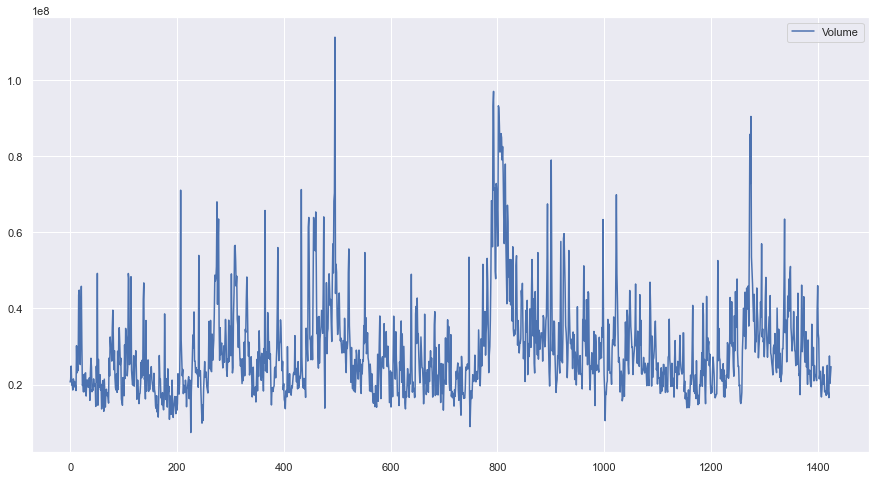

In [58]:
df_for_plot=df_for_training
df_for_plot.plot.line(figsize=(15,8))

In [59]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler =scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_training_scaled

array([[-0.65050546],
       [-0.59934343],
       [-0.31925529],
       ...,
       [-0.6786727 ],
       [-0.4863022 ],
       [-0.33090715]])

In [60]:
trainX=[]
trainY=[]

n_future = 1
n_past = 25

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    
trainX, trainY =np.array(trainX), np.array(trainY)

print('trainX shape==={}.'.format(trainX.shape))
print('trainY shape==={}.'.format(trainY.shape))

trainX shape===(1401, 25, 1).
trainY shape===(1401, 1).


In [62]:
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Bidirectional, BatchNormalization, Embedding

In [63]:
model = Sequential()

model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(trainX, trainY, epochs=62, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/62
79/79 [==============================] - 6s 20ms/step - loss: 0.9832 - val_loss: 0.4431
Epoch 2/62
79/79 [==============================] - 1s 15ms/step - loss: 0.9257 - val_loss: 0.4382
Epoch 3/62
79/79 [==============================] - 1s 15ms/step - loss: 0.8947 - val_loss: 0.4337
Epoch 4/62
79/79 [==============================] - 1s 15ms/step - loss: 0.8762 - val_loss: 0.4318
Epoch 5/62
79/79 [==============================] - 1s 17ms/step - loss: 0.9100 - val_loss: 0.4358
Epoch 6/62
79/79 [==============================] - 1s 16ms/step - loss: 0.9295 - val_loss: 0.4371
Epoch 7/62
79/79 [==============================] - 1s 12ms/step - loss: 0.8952 - val_loss: 0.4351
Epoch 8/62
79/79 [==============================] - 1s 12ms/step - loss: 0.8778 - val_loss: 0.4352
Epoch 9/62
79/79 [==============================] - 1s 12ms/step - loss: 0.8641 - val_loss: 0.4315
Epoch 10/62
79/79 [==============================] - 1s 13ms/step - loss: 0.8480 - val_loss: 0.4320
Epoch 11/

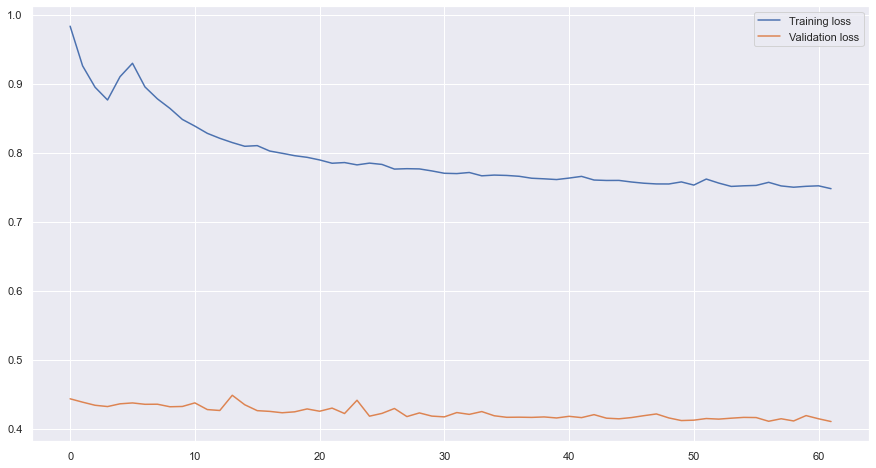

In [65]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [66]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [67]:
n_past = 10
n_days_for_prediction=100  

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [68]:
# make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

4/4 [==============================] - 0s 5ms/step


In [69]:
#Perform inverse transformation to rescale back to original range
#Since we used 1 variables for transform, the inverse expects same dimensions
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
prediction_copies.shape

(100, 32)

In [70]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [71]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Volume':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\Users\Taimoor M Gondal\AppData\Local\Temp\ipykernel_2868\985923314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
C:\Users\Taimoor M Gondal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Taimoor M Gondal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments w

<AxesSubplot:xlabel='Date', ylabel='Volume'>

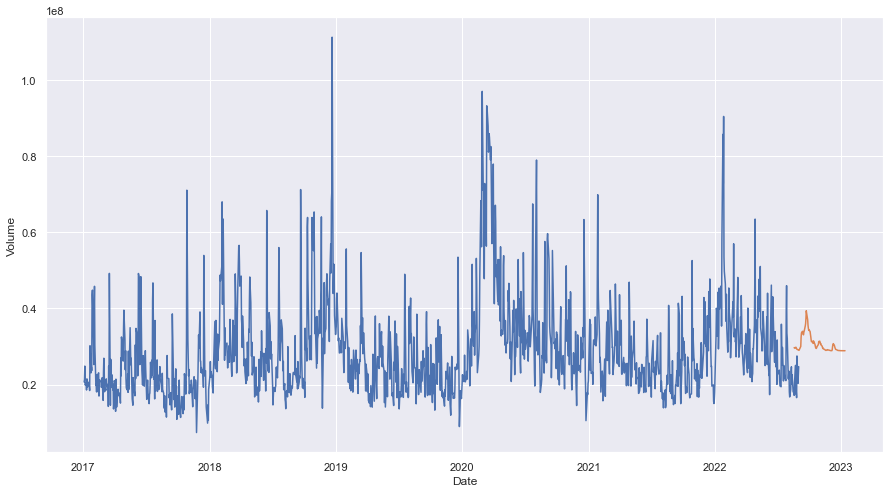

In [72]:

original = df[['Date', 'Volume']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2017-1-3']
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(original['Date'], original['Volume'])
sns.lineplot(df_forecast['Date'], df_forecast['Volume'])